In [18]:
import torch
import pandas as pd
import numpy as np
import math
import os
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

device = torch.device('cuda:0')

In [19]:
class PUBG_imglike_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        def transfrom2imglike(input):
            output = np.zeros((3,32,32))
            temp = np.array(input)
            for x in range(23):
                for y in range(23):
                    if(x == y):
                        output[0][x][y] = temp[x]
                        output[1][x][y] = temp[x]
                        output[2][x][y] = temp[x]
            return output
        # get one line in csv
        player_id = self.frame.iloc [idx, 0]
        player_stats = self.frame.iloc [idx, [x for x in range(3, 27) if x != 15]].values.astype(np.int_)
        player_stats = torch.tensor(transfrom2imglike(player_stats))
        win_place_perc = torch.tensor(self.frame.iloc [idx, 28])
        if self.transform:
            player_stats = self.transform(player_stats)
        sample = {
            "player_id": player_id, 
            "player_stats": player_stats,
            "win_place_perc": win_place_perc
        }
        return sample
    
def get_dataset(csv_file, train_dataset_size_ratio, batch_size):
    dataset = PUBG_imglike_dataset(csv_file)
    #  `torch.utils.data.random_split` meets server problem and lead to CRASH
    # see also:
    # - a denied fix PR for this problem: https://github.com/pytorch/pytorch/pull/9237 
    #train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor((1-train_dataset_size_ratio) * dataset_size))
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    print("load dataset: train dataset: {}, test dataset: {}.".format(len(train_loader)*batch_size, len(test_loader)*batch_size))
    return (train_loader, test_loader)

# load dataset
csv_file = 'train_small.csv'
train_dataset_size_ratio = 0.9
batch_size = 128
train_loader, test_loader = get_dataset(csv_file, train_dataset_size_ratio, batch_size)

load dataset: train dataset: 1152, test dataset: 128.


In [3]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

In [4]:
def train(model, train_loader, loss_func, optimizer, device):
    total_loss = 0
    # train the model using minibatch
    for i, data in enumerate(train_loader):
        stats, prec = data['player_stats'], data['win_place_perc']
        stats, prec = stats.to(torch.float32).to(device), prec.to(device)

        # forward
        outputs = model(stats)
        loss = loss_func(outputs, prec)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        #if (i + 1) % 10 == 0:
        #    print ("Step [{}/{}] Train Loss: {:.4f}".format(i+1, len(train_loader), loss.item()))
    #print ("Train Loss: {:.4f}".format(loss.item()))
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):

    model.eval()
    with torch.no_grad():
        loss = 0
        total = 0
        
        for i, data in enumerate(val_loader):
            stats, prec = data['player_stats'], data['win_place_perc']
            stats, prec = stats.to(torch.float32).to(device), prec.to(device)

            outputs = model(stats)

            
            loss += (torch.abs(torch.t(outputs) - prec)).sum()
            total += prec.size(0)

            
        accuracy = loss / total
        #print('Test Loss: {:.4f}'.format(accuracy))
        return accuracy
    
def fit(model, num_epochs, optimizer, device):
    loss_func = nn.MSELoss()
    model.to(device)
    if device == torch.device('cuda'):
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    loss_func.to(device)
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        

        # train step
        loss = train(model, train_loader, loss_func, optimizer, device)
        losses.append(loss)
        
        # evaluate step
        accuracy = evaluate(model, test_loader, device)
        accs.append(accuracy)
        
        # print loss
        if (epoch+1) % 10 == 0:
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("Train Loss: {:.4f}".format(loss))
            print('Test Loss: {:.4f}'.format(accuracy))

    show_curve(losses, "train loss")
    show_curve(accs, "test loss")

In [5]:
class Bottleneck(nn.Module):
    '''
        the above mentioned bottleneck, including two conv layer, one's kernel size is 1×1, another's is 3×3

        after non-linear operation, concatenate the input to the output
    '''
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        
        # input and output are concatenated here
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    '''
        transition layer is used for down sampling the feature
        
        when compress rate is 0.5, out_planes is a half of in_planes
    '''
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        
        out = self.conv(F.relu(self.bn(x)))
        # use average pooling change the size of feature map here
        out = F.avg_pool2d(out, 2)
        return out 

In [6]:
class Block(nn.Module):
    '''
        Grouped convolution block(c).
        
    '''
    expansion = 2

    def __init__(self, in_planes, cardinality=32, bottleneck_width=4, stride=1):
        '''
            in_planes: channel size of input
            cardinality: number of groups
            bottleneck_width: channel size of each group
        '''
        super(Block, self).__init__()
        group_width = cardinality * bottleneck_width
        self.conv1 = nn.Conv2d(in_planes, group_width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)
        # divide into 32 groups which 32 is cardinality
        self.conv2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width)
        self.conv3 = nn.Conv2d(group_width, self.expansion*group_width, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*group_width)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*group_width:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*group_width, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*group_width)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [7]:
class ResNeXt(nn.Module):
    def __init__(self, num_blocks, cardinality, bottleneck_width, num_classes=10):
        '''
            num_blocks: list type, channel size of input
            cardinality: number of groups
            bottleneck_width: channel size of each group
        '''
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # size 32x32
        self.layer1 = self._make_layer(num_blocks[0], 1)
        # size 32x32
        self.layer2 = self._make_layer(num_blocks[1], 2)
        # size 16x16
        self.layer3 = self._make_layer(num_blocks[2], 2)
        # size 8x8
        self.linear = nn.Linear(cardinality*bottleneck_width*8, num_classes)

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, self.cardinality, self.bottleneck_width, stride))
            self.in_planes = Block.expansion * self.cardinality * self.bottleneck_width
        # Increase bottleneck_width by 2 after each stage.
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [8]:
resnext32_16x8d =  ResNeXt([3,3,3], 16, 8, 1)

In [11]:
# training setting
# hyper parameters
num_epochs = 100
lr = 0.01
image_size = 32

# Device configuration, cpu, cuda:0/1/2/3 available
device = torch.device('cuda:3')

optimizer = torch.optim.Adam(resnext32_16x8d.parameters(), lr=lr)

Epoch 10/100
Train Loss: 0.0943
Test Loss: 0.2782
Epoch 20/100
Train Loss: 0.0929
Test Loss: 0.2781
Epoch 30/100
Train Loss: 0.1000
Test Loss: 0.2784
Epoch 40/100
Train Loss: 0.0925
Test Loss: 0.2782
Epoch 50/100
Train Loss: 0.0945
Test Loss: 0.2781
Epoch 60/100
Train Loss: 0.0945
Test Loss: 0.2793
Epoch 70/100
Train Loss: 0.0928
Test Loss: 0.2783
Epoch 80/100
Train Loss: 0.0951
Test Loss: 0.2779
Epoch 90/100
Train Loss: 0.0937
Test Loss: 0.2781
Epoch 100/100
Train Loss: 0.0923
Test Loss: 0.2779


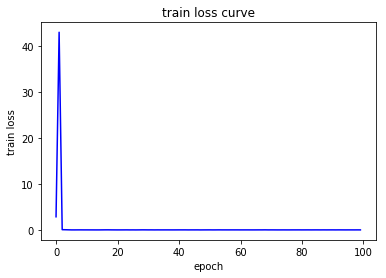

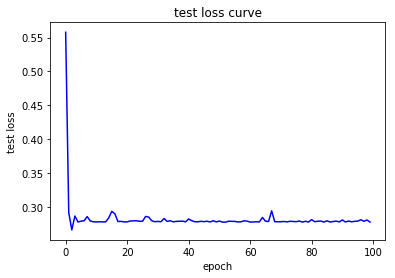

In [12]:
fit(resnext32_16x8d, num_epochs, optimizer, device)

Epoch 10/100
Train Loss: 0.0911
Test Loss: 0.2806
Epoch 20/100
Train Loss: 0.0920
Test Loss: 0.2806
Epoch 30/100
Train Loss: 0.0892
Test Loss: 0.2801
Epoch 40/100
Train Loss: 0.0935
Test Loss: 0.2801
Epoch 50/100
Train Loss: 0.0931
Test Loss: 0.2801
Epoch 60/100
Train Loss: 0.0931
Test Loss: 0.2799
Epoch 70/100
Train Loss: 0.0905
Test Loss: 0.2797
Epoch 80/100
Train Loss: 0.0892
Test Loss: 0.2795
Epoch 90/100
Train Loss: 0.0932
Test Loss: 0.2795
Epoch 100/100
Train Loss: 0.0901
Test Loss: 0.2797


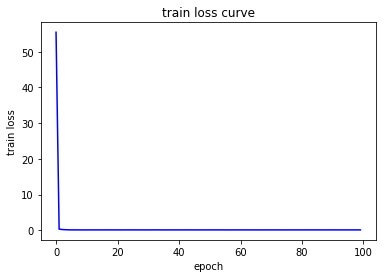

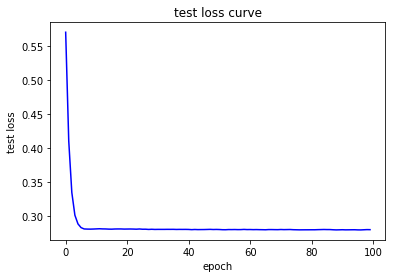

In [20]:
resnext32_16x8d =  ResNeXt([3,3,3], 16, 8, 1)
# training setting
# hyper parameters
num_epochs = 100
lr = 0.01
image_size = 32

# Device configuration, cpu, cuda:0/1/2/3 available
device = torch.device('cuda:3')

optimizer = torch.optim.SGD(resnext32_16x8d.parameters(), lr=lr)
fit(resnext32_16x8d, num_epochs, optimizer, device)

Epoch 10/100
Train Loss: 0.0923
Test Loss: 0.2805
Epoch 20/100
Train Loss: 0.0919
Test Loss: 0.2827
Epoch 30/100
Train Loss: 0.0970
Test Loss: 0.2780
Epoch 40/100
Train Loss: 0.0968
Test Loss: 0.2783
Epoch 50/100
Train Loss: 0.0942
Test Loss: 0.2906
Epoch 60/100
Train Loss: 0.0975
Test Loss: 0.2792
Epoch 70/100
Train Loss: 0.0966
Test Loss: 0.2873
Epoch 80/100
Train Loss: 0.0951
Test Loss: 0.3199
Epoch 90/100
Train Loss: 0.0952
Test Loss: 0.2792
Epoch 100/100
Train Loss: 0.0920
Test Loss: 0.2840


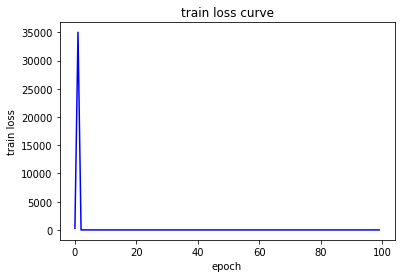

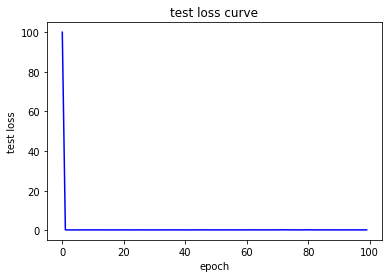

In [21]:
resnext32_16x8d =  ResNeXt([3,3,3], 16, 8, 1)
# training setting
# hyper parameters
num_epochs = 100
lr = 0.01
image_size = 32

# Device configuration, cpu, cuda:0/1/2/3 available
device = torch.device('cuda:3')

optimizer = torch.optim.RMSprop(resnext32_16x8d.parameters(), lr=lr)
fit(resnext32_16x8d, num_epochs, optimizer, device)

In [ ]:
通过比较test loss, SGD优化器的表现会更好一些

Epoch 10/400
Train Loss: 0.0945
Test Loss: 0.2749
Epoch 20/400
Train Loss: 0.0906
Test Loss: 0.2762
Epoch 30/400
Train Loss: 0.0905
Test Loss: 0.2770
Epoch 40/400
Train Loss: 0.0964
Test Loss: 0.2775
Epoch 50/400
Train Loss: 0.0912
Test Loss: 0.2777
Epoch 60/400
Train Loss: 0.0930
Test Loss: 0.2779
Epoch 70/400
Train Loss: 0.0913
Test Loss: 0.2776
Epoch 80/400
Train Loss: 0.0886
Test Loss: 0.2782
Epoch 90/400
Train Loss: 0.0925
Test Loss: 0.2785
Epoch 100/400
Train Loss: 0.0893
Test Loss: 0.2783
Epoch 110/400
Train Loss: 0.0916
Test Loss: 0.2780
Epoch 120/400
Train Loss: 0.0891
Test Loss: 0.2780
Epoch 130/400
Train Loss: 0.0936
Test Loss: 0.2781
Epoch 140/400
Train Loss: 0.0907
Test Loss: 0.2782
Epoch 150/400
Train Loss: 0.0884
Test Loss: 0.2782
Epoch 160/400
Train Loss: 0.0931
Test Loss: 0.2782
Epoch 170/400
Train Loss: 0.0942
Test Loss: 0.2783
Epoch 180/400
Train Loss: 0.0924
Test Loss: 0.2783
Epoch 190/400
Train Loss: 0.0929
Test Loss: 0.2783
Epoch 200/400
Train Loss: 0.0952
Test Lo

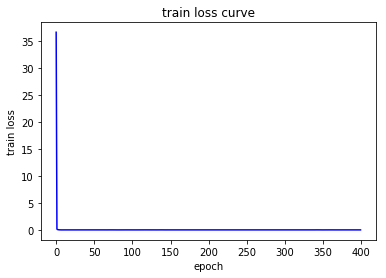

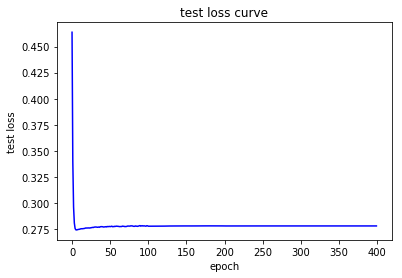

In [22]:
from torch.optim import lr_scheduler
def fit2(model, num_epochs, optimizer, device):
    loss_func = nn.MSELoss()
    model.to(device)
    if device == torch.device('cuda'):
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    loss_func.to(device)
    losses = []
    accs = []
    
    scheduler = lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.1)
    
    for epoch in range(num_epochs):
        

        # train step
        loss = train(model, train_loader, loss_func, optimizer, device)
        losses.append(loss)
        
        # evaluate step
        accuracy = evaluate(model, test_loader, device)
        accs.append(accuracy)
        # change the learning rate by scheduler
        scheduler.step()
        
        # print loss
        if (epoch+1) % 10 == 0:
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("Train Loss: {:.4f}".format(loss))
            print('Test Loss: {:.4f}'.format(accuracy))

    show_curve(losses, "train loss")
    show_curve(accs, "test loss")
    
resnext32_16x8d =  ResNeXt([3,3,3], 16, 8, 1)
# training setting
# hyper parameters
num_epochs = 400
lr = 0.01
image_size = 32

# Device configuration, cpu, cuda:0/1/2/3 available
device = torch.device('cuda:3')

optimizer = torch.optim.SGD(resnext32_16x8d.parameters(), lr=lr)
fit2(resnext32_16x8d, num_epochs, optimizer, device)